In [1]:
from skimage.util.shape import view_as_windows
from numpy.linalg import eig
import numpy as np
import scipy
import scipy.linalg as linalg # SciPy Linear Algebra Library
import pandas as pd
import matplotlib.pyplot as plt

"""
for function, reference to:https://stackoverflow.com/questions/52463972/...
generating-banded-matrices-using-numpy#:~:text=def%20sliding_windows_vw...
(a%2C%20W)%3A%0A%20%20%20%20a%20%3D%20np.asarray(a)%0A%20%20%20%20p%20%3D%...
20np.zeros(W%2D1%2Cdtype%3Da.dtype)%0A%20%20%20%20b%20%3D%20np.concatenate((...
p%2Ca%2Cp))%0A%20%20%20%20return%20view_as_windows(b%2Clen(a)%2BW%2D1)%5B%3A%3A%2D1%5D
"""
def sliding_windows_vw(a, W):
    a = np.asarray(a)
    p = np.zeros(W,dtype=a.dtype)
    b = np.concatenate((p,a,p))
    return view_as_windows(b,len(a)+W-1)[::-1]

def generate_3_band_matrix(a,b,c,W):
    arr = [a,b,c]    
    return sliding_windows_vw(arr, W)
    
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)
def matplot_sparse_matrix(L, title, cmap_name =plt.cm.PiYG):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.matshow(L, cmap=cmap_name)
    plt.title(title)
    
# reference: https://python.quantecon.org/qr_decomp.html
def QR_Decomposition(A):
    n, m = A.shape # get the shape of A

    Q = np.empty((n, n)) # initialize matrix Q
    u = np.empty((n, n)) # initialize matrix u

    u[:, 0] = A[:, 0]
    Q[:, 0] = u[:, 0] / np.linalg.norm(u[:, 0])

    for i in range(1, n):

        u[:, i] = A[:, i]
        for j in range(i):
            u[:, i] -= (A[:, i] @ Q[:, j]) * Q[:, j] # get each u vector

        Q[:, i] = u[:, i] / np.linalg.norm(u[:, i]) # compute each e vetor

    R = np.zeros((n, m))
    for i in range(n):
        for j in range(i, m):
            R[i, j] = A[:, j] @ Q[:, i]

    return Q, R

def QR_Algortihm(A):
    check_diag = [False] * A.shape[0]
    flag = True
    counter = -1
    while flag:
        counter += 1
        temp = A.copy()
        Q, R = QR_Decomposition(A)
        A = np.dot(R,Q)
        if counter % 50 == 0:
            matplot_sparse_matrix(A, "Iteration-"+str(counter))
        
        # Stopping criteria
        for i in range(A.shape[0]):
            check_diag[i] = np.allclose(temp[i][i], A[i][i])
        if np.array(check_diag).all():
            print("Stopped Iteration Number ",counter)
            flag = False
            
    matplot_sparse_matrix(A, "Iteration-"+str(counter))
    return A
    

In [2]:
class Toeplitz:
    def __init__(self,a,b,c, N):
        self.n = N
        self.A = generate_3_band_matrix(a,b,c, (self.n - 2))
        self.QRsigma = []        
        self.SVDsigma = None
        self.SVDu = None
        self.SVDs = None
        self.SVDvH = None
        self.LowRank = None
        if is_pos_def(self.A):
            print("Generated matrix is positive definite. :)")
        else:
            print("Generated matrix is not positive definite. :/")
    
    def QR(self):
        A_app = QR_Algortihm(self.A)        
        for i in range(self.n):
            self.QRsigma.append(A_app[i][i])       
    def SVD(self):
        self.SVDu, self.SVDs, self.SVDvH = linalg.svd(self.A)
        self.SVDsigma =list(self.SVDs)
        
    def _plotSigma(self):
        r = np.linspace(1,20,num=20)
        fig, ax = plt.subplots()
        plt.stem(r, self.SVDsigma) 
        plt.xlabel('Eigenvalue Number')
        plt.ylabel('Eigenvalues') 
        plt.title('Eigenvalues of A')
        plt.xticks(r)
        plt.show() 
        
        
    def compareSigma(self):            
        diff = np.abs(np.array(self.QRsigma) - np.array(self.SVDsigma))
        df = pd.DataFrame(list(zip(self.QRsigma, self.SVDsigma, list(diff))), columns=["QR Sigma", "SVD Sigma", "Abs Differences"])
        display(df)
        self._plotSigma()
        
    def bestLowRank(self, rank):
        u = self.SVDu[:,:rank]
        vh = self.SVDvH[:rank,:]
        s = self.SVDs[:rank]
        s = np.diag(s)
        self.LowRank = np.dot(np.dot(u,s), vh)
    
    def analyzeBestLowRank(self, maxRank):
        r = []
        error = []
        for rank in range(maxRank):
            self.bestLowRank(rank)
            error.append(np.linalg.norm(self.A-self.LowRank))
            r.append(rank+1)
        # Plot parameters
        plt.stem(r, error) 
        plt.xlabel('k')
        plt.ylabel('||A-Ak||2') 
        plt.xticks(r)
        plt.title('The Best Low Rank Approximation')
        plt.show() 

            
        

        

In [3]:
hw4 = Toeplitz(-1,2,-1,20)
print(hw4.A)

Generated matrix is positive definite. :)
[[ 2 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [-1  2 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  2 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  2 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  2 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  2 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  2 -1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 -1  2 -1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  2 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  2 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 -1  2 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  2 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  2 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  2 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  2 -1  0  0  0  0]
 [ 0  0  0  0

Stopped Iteration Number  159
[3.9765022034263646, 3.912111765798464, 3.8021180979810523, 3.6524899522498893, 3.46610425838295, 3.246979617744902, 3.0000000002500626, 2.7306820487355647, 2.445041867912644, 2.1494601871728523, 1.85053981282715, 1.5549581320873715, 1.2693179512672093, 1.0000000000000022, 0.7530203962825338, 0.5338962563403469, 0.3475224513680099, 0.198062264195161, 0.08885438842771776, 0.02233834754974009]


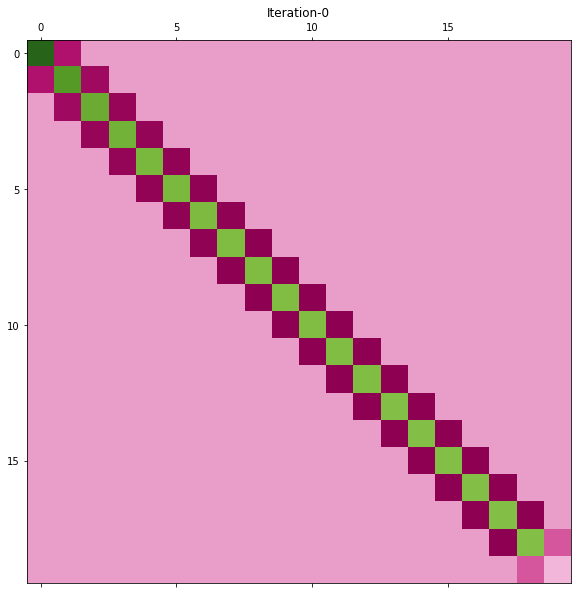

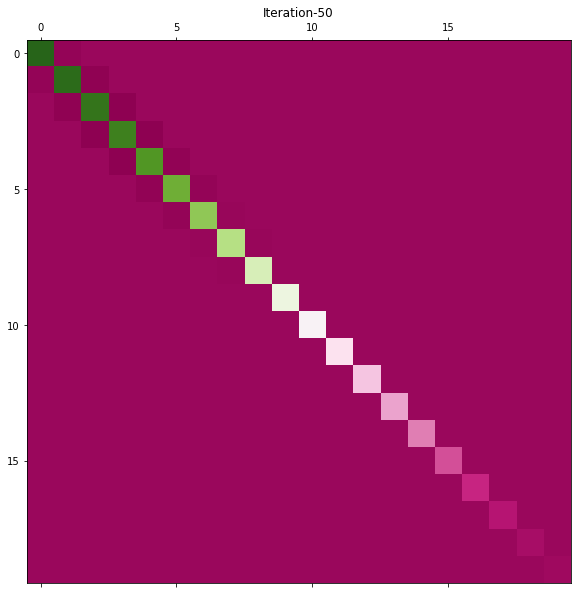

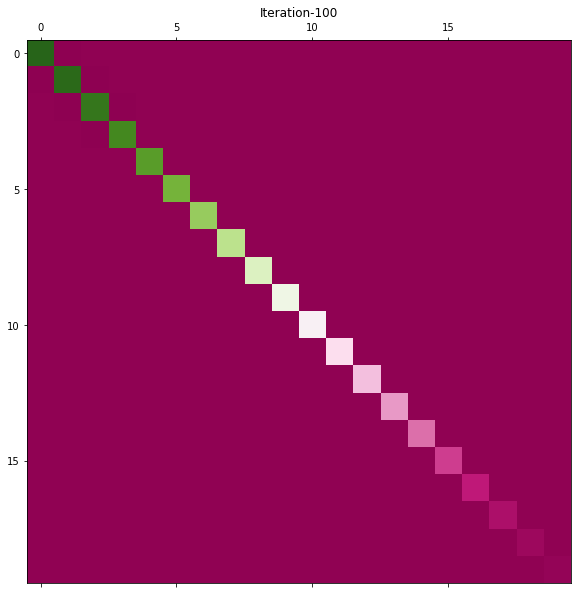

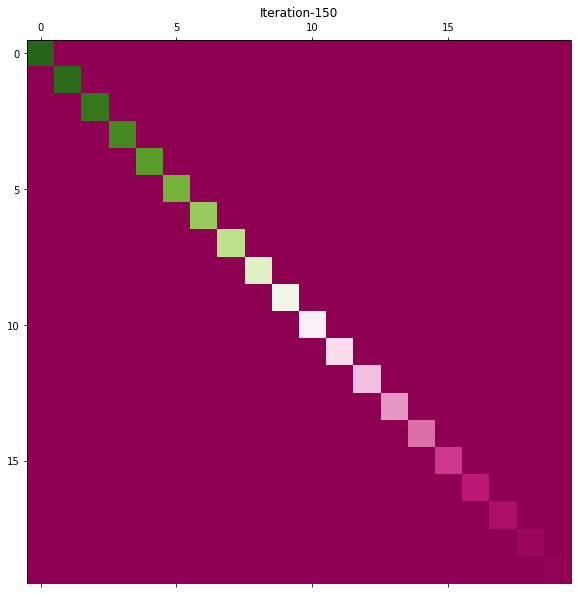

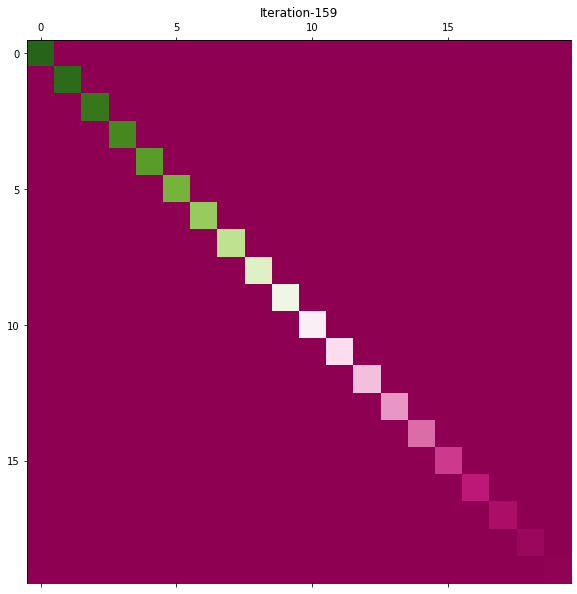

In [4]:
hw4.QR()
print(hw4.QRsigma)

,QR Sigma,SVD Sigma,Abs Differences
0,3.976502,3.977662,1.159449e-03
1,3.912112,3.911146,9.661542e-04
2,3.802118,3.801938,1.803622e-04
3,3.652490,3.652478,1.240362e-05
4,3.466104,3.466104,5.147233e-07
5,3.246980,3.246980,1.402744e-08
6,3.000000,3.000000,2.500657e-10
7,2.730682,2.730682,2.776002e-12
8,2.445042,2.445042,1.465494e-14
9,2.149460,2.149460,4.440892e-15


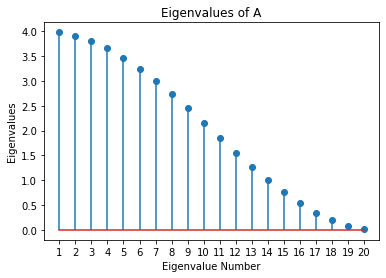

In [5]:
hw4.SVD()
hw4.compareSigma()

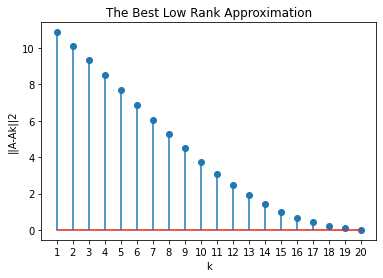

In [6]:
hw4.analyzeBestLowRank(20)

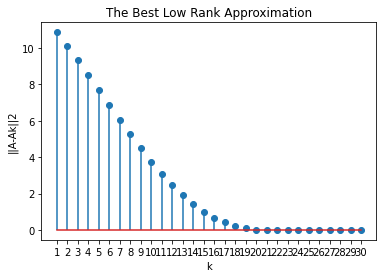

In [7]:
hw4.analyzeBestLowRank(30)